# Terminal Link Optimization

This is the main ipython script for the terminal link optimization algorithm.
I will update the documentation accordingly once the project has progressed further.

## Import packages

In [1]:
import tensorflow as tf
tf.enable_eager_execution()
tfe = tf.contrib.eager

from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import matplotlib.pyplot as plt


from tensorflow.keras import datasets, layers, models

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



## Make simulation of satellite and customers

Lets first start by simulating customers on the ground. This will essentially 
end up being a straight line with dots (representing customers) being randomly 
distributed along the line. The line will be spaced according to some 
arbitrary time metric. Each customer will have (for now) 4 attributes which 
describe the "importantness" of each customer.

In [0]:
"""
Lets make an array containing the physical location of some simulated customers.
The array will have the shape (N_time_segments,length_of_time_segment)

customer data array `customer_arr` will be of shape (number of training orbits, number of customers 
in orbit, number of features describing priority of customers)
"""

# training set hyperparameters
num_customers = 100 # total number of customers on planet
num_orbits = 10000  # total number of training samples (in this case orbits)
max_dist = 1000    # maximum distance allowed for customers
dist_step = 2000     # distance traveled per step by satellite
obs_window = 2000    # total size of observation window of satellite in units of distance
customer_arr = np.zeros((num_orbits,num_customers,5)) # Define emtpy array to contain customer data

# neural network hyperparameters
batch_size = 64

# Make training set
for i in range(num_orbits):
    # Make customer index labels
    customer_arr[i,:,0] = np.arange(start=0,stop=num_customers,step=1)

    # Define random locations of customers on a line defining the planet
    customer_arr[i,:,1] = np.random.randint(low=0,high=max_dist,size=(num_customers))

    # Assign a random customer important factor. 0 == low importance, 1 == high importance
    customer_arr[i,:,2] = np.random.uniform(low=0.0,high=1.0,size=(num_customers))

    # Assign a random customer weather factor. 0 == high cloud coverage, 1 == low cloud coverage
    customer_arr[i,:,3] = np.random.uniform(low=0.0,high=1.0,size=(num_customers))

# Testing set hyperparameters
num_test_orbits = 100 # number of test samples to use
customer_test_arr = np.zeros((num_test_orbits,num_customers,5))

# Make test set
for i in range(num_test_orbits):
    # Make customer index labels
    customer_test_arr[i,:,0] = np.arange(start=0,stop=num_customers,step=1)

    # Define random locations of customers on a line defining the planet
    customer_test_arr[i,:,1] = np.random.randint(low=0,high=max_dist,size=(num_customers))

    # Assign a random customer important factor. 0 == low importance, 1 == high importance
    customer_test_arr[i,:,2] = np.random.uniform(low=0.0,high=1.0,size=(num_customers))

    # Assign a random customer weather factor. 0 == high cloud coverage, 1 == low cloud coverage
    customer_test_arr[i,:,3] = np.random.uniform(low=0.0,high=1.0,size=(num_customers))

In [0]:
# training features: location, importance, weather
X_train = customer_arr[:,:,1:4]
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],X_train.shape[2],1)
X_test = customer_test_arr[:,:,1:4].reshape(num_test_orbits,num_customers,3,1)
Y_train = np.ones((num_orbits,num_customers))
Y_test = np.ones((num_test_orbits,num_customers))

## Choose optimal order in which to distribute keys (simple approach)

This is an incredibly simple algorithm which only takes into account 
the importantness and weather factors for each customer. It does not 
take into account the total time customers have been waiting for 
a key to be distributed to them.

In [0]:
# Loop over all available customers within line-of-sight (this is by default set to num_customers)
# This is an example using only one training orbit.
for i in range(num_customers):
    customer_arr[0,i,4] = customer_arr[0,i,2] * customer_arr[0,i,3]

customer_prob_list_idx = np.argsort(customer_arr[0,:,4])
customer_prob_list = customer_arr[0,customer_prob_list_idx,0]

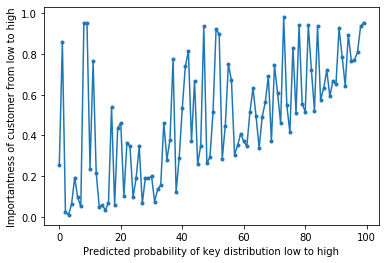

In [5]:
# Plot importantness as a function of predicted key probability
plt.plot(customer_arr[0,customer_prob_list_idx,2], marker='.')
plt.xlabel('Predicted probability of key distribution low to high')
plt.ylabel('Importantness of customer from low to high')
plt.show()

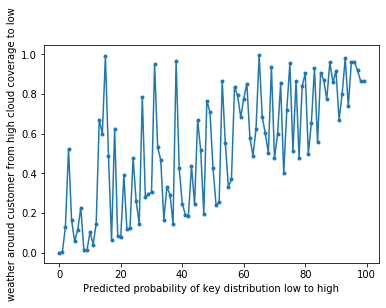

In [6]:
# Plot weather as a function of predicted key probability
plt.close()
plt.plot(customer_arr[0,customer_prob_list_idx,3], marker='.')
plt.xlabel('Predicted probability of key distribution low to high')
plt.ylabel('weather around customer from high cloud coverage to low')
plt.show()

## Neural Network Approach (complicated approach)

I've written some pseudo code down on a piece of paper. Not guranteeing that 
this will actually work in practice, but I will make my first attempt of this here. 

Need to eventually take into account the fact that we will see the customer 
multiple times over several days. Will also need to account for a decrease 
in priority for those customers at much greater distances, since it takes 
longer to distribute keys as the distance between satellite and ground terminal 
increases.

### Define TensorFlow network archetecture

In [0]:
def custom_loss(output=None, target=None, batch_feature_data=None, tape=None, model=None):
    """ This is a custom loss function which 
    takes as input the raw output from the neural 
    network and returns a loss which attempts to 
    minimize the number of keys not distributed 
    within the alloted amount of time.
    """
    
    def my_model(output, batch_feature_data):
        """ This is a model which will iterate 
        over the predicted ordering of keys to be 
        distributed. There will be a penalty 
        associated with any keys which are predicted to 
        be distributed outside of the obersvation window.
        """

        # Assume 5 seconds to distribute key to customer downstream
        # Array to store the calculated number of keys lying outside of time alloted
#        new_output = tf.zeros((batch_feature_data.shape[0],num_customers))
#        new_output = np.zeros((batch_feature_data.shape[0],num_customers))

        # Make sure to delete the dummy tensor from previous runs
        try:
          batch_dummy_tensor
          del batch_dummy_tensor
        except NameError:
          None

        # Iterate over all samples in batch 
        for i in range(batch_size):

#          print('Starting operations on sample %d' % i)
          # Get predicted output for current sample in batch

          tmp_output = output[i,:]

          dist_cnt = 0
          customers_accessed = []     # list to store customers who have already had a key distributed to them

          # Make sure to delete the dummy tensors from previous batch samples
          try: 
            train_samp_dummy_tensor
            del train_samp_dummy_tensor
          except NameError:
            None

          # Simulate satellite traveling until maximum distance reached (defined as 1 orbit around Earth)
          while dist_cnt <= max_dist:       

            customers_in_cur_wind_prob = []
            customers_in_cur_wind_idx = []
            customers_in_cur_wind_feat = []
            
            # Iterate over all customers around the globe
            for customer_idx,customer in enumerate(batch_feature_data[i,:,:].numpy()):
 
              # If the location of a customer lies within the line-of-sight of satellite 
              if customer[0] < (dist_cnt + obs_window) and customer[0] > (dist_cnt) :
                # Check if customer has already had a key distributed to them
                try:
                    customers_accessed.index(customer_idx)
                except ValueError:
                    None
                else:
                    continue

                # Append predicted probability of key being distributed
                customers_in_cur_wind_prob.append(tmp_output[customer_idx])

                # Append the index of the customer
                customers_in_cur_wind_idx.append(customer_idx)

                # Append loss value of customer
                customers_in_cur_wind_feat.append(customer[1]*customer[2])            

            # If there are no customers within the current line-of-sight, add some small distance traveled to satellite
            if not customers_in_cur_wind_prob:
              dist_cnt+=dist_step
              continue
            
            customers_in_cur_wind_idx = customers_in_cur_wind_idx
            # Of all customers within line-of-sight, choose one with max probability
            max_cust = tf.gather(customers_in_cur_wind_idx, tf.argmax(tf.gather(tmp_output,customers_in_cur_wind_idx)))
#            max_cust = customers_in_cur_wind_idx.get_item(tf.math.argmax(tmp_output[customers_in_cur_wind_idx]))
            # Add customer to list of keys already delivered
            customers_accessed.append(max_cust.numpy())

            # Add to batch sample loss max prob customer weather and importantness scaled by predicted probability of key distribution
#            new_output = tf.concat(new_output, (tmp_output[max_cust]**1 * 
#                                                          batch_feature_data[i,max_cust,1]**1 *
#                                                          batch_feature_data[i,max_cust,2]**1))
            max_cust = max_cust.numpy()
#            print(gr_tape.gradient(tmp_output[max_cust],output))
            """
            # TODO: Need to figure out a way to not use .eval() here!! Otherwise 
            you loose gradient!! Try using the tensorflow concatenate function. 
            This should preserve any tensorflow operations performed before 
            """

#            new_output[i,max_cust] = tf.add(tf.convert_to_tensor(new_output[i,max_cust], dtype=tf.float32), (tmp_output[max_cust]**1 * 
#                                                          batch_feature_data[i,max_cust,1]**1 *
#                                                          batch_feature_data[i,max_cust,2]**1)).eval()
            # check if the training sample customer loop variable exists

            #print(tmp_output.shape)
            #print(tape.gradient(tf.gather(tmp_output,max_cust), tmp_output))
            #stop

            try:
              train_samp_dummy_tensor
            except NameError:
              train_samp_dummy_tensor = tf.Variable(tmp_output[max_cust]**1 * 
                                         tf.Variable(batch_feature_data[i,max_cust,1], dtype=tf.float32)**1 *
                                         tf.Variable(batch_feature_data[i,max_cust,2], dtype=tf.float32)**1)
              
            # if it does exist, add it to existing customer list
            else:
              train_samp_dummy_tensor = tf.concat([train_samp_dummy_tensor, tf.Variable(tmp_output[max_cust]**1 * 
                                                          tf.Variable(batch_feature_data[i,max_cust,1], dtype=tf.float32)**1 *
                                                          tf.Variable(batch_feature_data[i,max_cust,2], dtype=tf.float32)**1)], axis=0)

            # Add a distance traveled by satellite (dist_step)
            dist_cnt+=dist_step

          """
          # TODO: Need to somehow organize the outputs such that it is the same order as that which it went in
          """
          # Sort delivered keys from closest to farthest away
          train_samp_dummy_tensor = tf.gather(train_samp_dummy_tensor, tf.argsort(customers_accessed))

          dummy_idx = 0
          # Iterate through keys delivered
          for customer_idx,customer in enumerate(batch_feature_data[i,:,:].numpy()):
            # Was key delivered?
            try:
              customers_accessed.index(customer_idx)
            # If not delivered, Give penalty of zero
            except ValueError:
              # Check if the final tensor has been created
              try:
                train_samp_tensor_final
              # If new final tensor hasn't been created, make a new one
              except NameError:
                # if this is the first customer and the key wasn't delivered, set output to zero
                if customer_idx == 0:
                  train_samp_tensor_final = tf.expand_dims(tf.gather(tmp_output, customer_idx)*0, axis=0)
              # if keys were delivered before this key which wasn't delivered append new result to final tensor
              else:
                train_samp_tensor_final = tf.concat([train_samp_tensor_final, 
                                                 tf.expand_dims(tf.gather(tmp_output, customer_idx)*0, axis=0)], axis=0)
            # If key was delivered, assign positive reward to final tensor 
            else:
              # Check if the final tensor has been created
              try:
                train_samp_tensor_final
              # If new final tensor hasn't been created, make a new one
              except NameError:
                if customer_idx == 0:
                  # If this is the first customer and the key WAS delivered, set output to precomputed reward from model
                  train_samp_tensor_final = tf.expand_dims(train_samp_dummy_tensor[dummy_idx], axis=0)
              else:
                train_samp_tensor_final = tf.concat([train_samp_tensor_final, 
                                                 tf.expand_dims(train_samp_dummy_tensor[dummy_idx], axis=0)], axis=0)


                dummy_idx+=1

          # Add computed loss for current sample to batch loss
          try:
            batch_dummy_tensor
          except NameError:
            batch_dummy_tensor = tf.expand_dims(train_samp_tensor_final, axis=0)
            del train_samp_tensor_final
          else:
            batch_dummy_tensor = tf.concat([batch_dummy_tensor, tf.expand_dims(train_samp_tensor_final, axis=0)], axis=0)
            del train_samp_tensor_final

          #print(len(customers_accessed)) 
          #print('Found %d cutomers inside required window of operation' % num_inside_dist)
    
        return batch_dummy_tensor

    # record all gradient operations done to predicted output from NN
#    with tf.GradientTape(persistent=True) as gr_tape:
#        gr_tape.watch(output)

    # Get number of keys predicted to be outside of target window
    pred_model_score = my_model(output, batch_feature_data)
    #print(output.shape, np.array(model.variables).shape)
    #print(tape.gradient(pred_model_score,model.variables))
    #print(pred_model_score)
    #print(tape.gradient(output, model.variables))
    #stop

        # Normalize score to be between zero and 1
    #    pred_model_score = torch.div( pred_model_score, torch.max(pred_model_score))
        #print(pred_model_score)

        # Compute mean squared loss between predictions and target
    #    loss *= 100
    return tf.reduce_mean(tf.squared_difference(pred_model_score, tf.Variable(target, dtype=tf.float32)))

In [0]:
def grad(model, inputs, targets):
  with tf.GradientTape() as tape:
    tape.watch(inputs)
    output = model(inputs)
    loss_value = custom_loss(output=output, target=targets, batch_feature_data=inputs, tape=tape, model=model)
  return tape.gradient(loss_value, model.variables)

In [9]:
# This approach uses the TensorFlow neural network library

# tf Graph input. We will flatten out input.
#x = tf.placeholder(tf.float32, [None, X_train.shape[1], X_train.shape[2],1])
#y = tf.placeholder(tf.float32, [None, Y_train.shape[1]])
#output_placeholder = tf.placeholder(tf.float32, [None, X_train.shape[1], X_train.shape[2],1])

# Simple function to do convolution layer
def conv2d(x, W):
  return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

# Simple function to pooling layer
def maxpool2d(x):
  return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

# Define the convolutional model (convolutional neural network)
def convolutional_neural_network(x):#, keep_rate):
    weights = {
        # 5 x 5 convolution, 1 input image, 32 outputs
        'W_conv1': tf.Variable(tf.random_normal([3, 1, 1, 32])),
        # 5x5 conv, 32 inputs, 64 outputs 
        'W_conv2': tf.Variable(tf.random_normal([3, 1, 32, 64])),
        # fully connected, 7*7*64 inputs, 1024 outputs
        'W_fc': tf.Variable(tf.random_normal([(64*num_customers*3), 1024])),
        # 1024 inputs, 10 outputs (class prediction)
        'out': tf.Variable(tf.random_normal([1024, num_customers]))
    }

    biases = {
        'b_conv1': tf.Variable(tf.random_normal([32])),
        'b_conv2': tf.Variable(tf.random_normal([64])),
        'b_fc': tf.Variable(tf.random_normal([1024])),
        'out': tf.Variable(tf.random_normal([num_customers]))
    }

    # Reshape input to a 4D tensor 
    x = tf.reshape(x, shape=[-1, num_customers, 3, 1])
    # Convolution Layer, using our function
    conv1 = tf.nn.relu(conv2d(x, weights['W_conv1']) + biases['b_conv1'])
    # Max Pooling (down-sampling)
#    conv1 = maxpool2d(conv1)
    # Convolution Layer
    conv2 = tf.nn.relu(conv2d(conv1, weights['W_conv2']) + biases['b_conv2'])
    # Max Pooling (down-sampling)
#    conv2 = maxpool2d(conv2)

    # Fully connected layer
    # Reshape conv2 output to fit fully connected layer
    fc = tf.reshape(conv2, [batch_size, num_customers*64*3])
    fc = tf.nn.relu(tf.matmul(fc, weights['W_fc']) + biases['b_fc'])

    output = tf.sigmoid(tf.matmul(fc, weights['out']) + biases['out'])
    return output

def train_keras_neural_network(X_train,Y_train):

  # Define the keras CNN model
  model = models.Sequential()
  model.add(layers.Conv2D(32, kernel_size=(2, 2), strides=(1, 1),
                 activation='relu',
                 input_shape=(num_customers,3,1)))
#  model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
  model.add(layers.Conv2D(64, (2, 2), activation='relu'))
#  model.add(layers.MaxPooling2D(pool_size=(2, 2)))
  model.add(layers.Flatten())
  model.add(layers.Dense(100, activation='relu'))
  model.add(layers.Dense(num_customers, activation='sigmoid'))

  print(model.summary())

  optimizer = tf.keras.optimizers.SGD(lr=0.01)

  hm_epochs = 10

  # Iterate over pre-defined number of training epochs
  for epoch in range(hm_epochs):
    i_batch = 0
    
    # Start iteration over current epoch in batches
    for batch in dataset:
      i_batch+=batch_size
#      if (num_orbits - (batch_size * i_batch)) < batch_size:
#        break
        
      epoch_x = tf.cast(batch[0], dtype=tf.float32)
      epoch_y = tf.cast(batch[1], dtype=tf.float32)

      grads = grad(model, epoch_x, epoch_y)

      optimizer.apply_gradients(zip(grads, model.variables))

      prediction = model(epoch_x)

      print("Loss at batch {:03d}: {:.3f}".format(i_batch, custom_loss(output=prediction, target=epoch_y, batch_feature_data=epoch_x)))

      model.save('my_trained_model.h5')


def train_tf_neural_network(X_train,Y_train):
    prediction = convolutional_neural_network(x=x)
#    cost = tf.reduce_mean(tf.squared_difference(prediction, y)) # cost is mean squared error
    cost = custom_loss(output=y, target=y, batch_feature_data=x)
    print(cost)
    stop

    optimizer = tf.train.AdamOptimizer.minimize(cost)
    print('Made it past initilization stage')
    stop
    
    hm_epochs = 10
    # setup the variable initialisation
    init_op = tf.global_variables_initializer()
    # Start TensorFlow training session
    with tf.Session() as sess:
        sess.run(init_op)
        sess.run(iterator.initializer)

        # Iterate over pre-defined number of training epochs
        for epoch in range(hm_epochs):
            epoch_loss = 0
            i_batch = 0
            # Start iteration over current epoch in batches
            for _ in range(int(num_orbits/batch_size)):
                i_batch += batch_size
                if (num_orbits - (batch_size * i_batch)) < batch_size:
                   break
                val = sess.run(next_element)
                epoch_x, epoch_y = val[0], val[1]
                out_pred = sess.run([prediction], feed_dict={x: epoch_x})
                out_loss = custom_loss(output=tf.convert_to_tensor(out_pred[0], dtype=tf.float32), target=epoch_y, batch_feature_data=epoch_x)
                sess.run([optimizer.minimize(out_loss)])
                print(i_batch)
                stop

                epoch_loss += out_loss / int(num_orbits/batch_size)

            print('Epoch', epoch, 'completed out of',hm_epochs,'loss:',epoch_loss)

        #correct = tf.equal(tf.argmax(prediction, 1), tf.argmax(y, 1))

        #accuracy = tf.reduce_mean(tf.cast(correct, 'float'))
        #print('Accuracy:',accuracy.eval({x:X_test, y:Y_test}))

        pred_test = sess.run(prediction, feed_dict={x: X_test[:batch_size]})
        print(pred_test)


# Make tensorflow dataset
dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
dataset = dataset.batch(batch_size=batch_size)
# Create the iterator
#iterator = dataset.make_initializable_iterator()
# Get first batch of iterator
#next_element = iterator.get_next()

# Train network
#train_tf_neural_network(X_train, Y_train)
train_keras_neural_network(X_train, Y_train)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 99, 2, 32)         160       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 98, 1, 64)         8256      
_________________________________________________________________
flatten (Flatten)            (None, 6272)              0         
_________________________________________________________________
dense (Dense)                (None, 100)               627300    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
Total params: 645,816
Trainable params: 645,816
Non-trainable params: 0
_________________________________________________________________
None
Instructions for updating:
Use tf.identity instead.
Loss at batch 064: 0.997
Loss at batch 128: 0.996
Loss at b

KeyboardInterrupt: ignored

In [0]:
"print(X_train.shape)


Need to fix loss function, such that it is differentiable. This can be done by 
scaling the loss calculated for each customer by the predicted probability 
associated with each customer. We would try to maximize the cost function associated with those who had keys distributed to them, rather than minimize the cost function associated with those who did not get keys distributed to them. See picture on your phone for more details.


### Plot Results

In [10]:
my_trained_model = models.load_model('my_trained_model.h5')

In [0]:
test_preds = my_trained_model(tf.cast(X_test, dtype=tf.float32))

In [13]:
print(X_test.shape, test_preds.shape)

(100, 100, 3, 1) (100, 100)


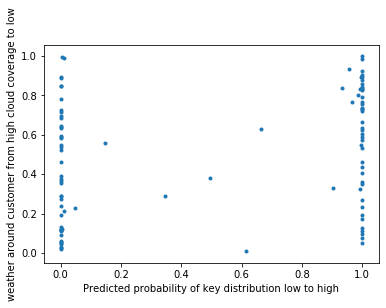

In [14]:
# plot weather results
plt.close()
plt.scatter(test_preds[0,:], X_test[0,:,2,0], marker='.')
plt.xlabel('Predicted probability of key distribution low to high')
plt.ylabel('weather around customer from high cloud coverage to low')
plt.show()